In [42]:
%matplotlib inline

import pandas as pd
import numpy as np


## Read in csv file

Remember to replace with your own file path

In [54]:
bike_df = pd.read_csv("/Users/jeff/bike_data/data/df.csv", parse_dates=[6, 7, 8, 9, 11, 13, 14])

#print dataframe columns
print(bike_df.columns)

#print the 10th row of the dataframe
print("Here is the 10th row!")
print(bike_df.ix[9])


Index([u'EndStationName', u'StartStationName', u'SubscriberID', u'MemberType',
       u'TripDurationSec', u'BikeID', u'StartDay', u'StartDateTime',
       u'StartDate', u'StartTime', u'StartStationID', u'EndDay',
       u'EndDateTime', u'EndDate', u'EndTime', u'EndStationID',
       u'tripDurationHours', u'yearStart', u'monthStart', u'latlonStart',
       u'latlonEnd'],
      dtype='object')
Here is the 10th row!
EndStationName        100 Manufacturers Rd
StartStationName        High St & E 2nd St
SubscriberID                         33691
MemberType                        Customer
TripDurationSec                       2330
BikeID                              C00132
StartDay                          Saturday
StartDateTime          2014-02-22 13:34:00
StartDate              2014-02-22 00:00:00
StartTime              2015-12-08 13:34:00
StartStationID                        1321
EndDay                            Saturday
EndDateTime            2014-02-22 14:13:00
EndDate                2

## Plot histogram of Stations

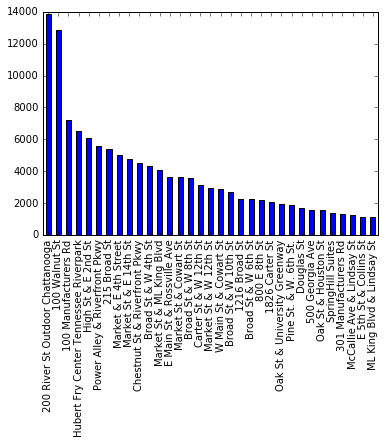

In [55]:
# Group stations
grouped_df = bike_df["StartStationName"].value_counts()

# Make bar chart
grouped_df.plot(kind="bar")


In [56]:
grouped_by_bikes = bike_df.groupby("BikeID")

print(type(bike_df["StartDateTime"].ix[0]))

for df in grouped_by_bikes:
    print((df[1]["EndDateTime"] - df[1]["StartDateTime"]).sum())

<class 'pandas.tslib.Timestamp'>


TypeError: ufunc subtract cannot use operands with types dtype('O') and dtype('<M8[ns]')

In [ ]:
a